In [3]:
import seaborn as sns
from keras.preprocessing.sequence import TimeseriesGenerator
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from pylab import rcParams
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 22, 10
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
scaler = MinMaxScaler()

sdf = pd.read_csv('sales dataset.csv')
sdf['salesDate'] = pd.to_datetime(sdf['salesDate'], infer_datetime_format=True)

In [4]:
selected_columns =['expenseAmount', 'expenseDate']
edf = edf[selected_columns]

In [12]:
sdf['sYear'] = sdf['salesDate'].dt.year
sdf['sMonth'] = sdf['salesDate'].dt.month
sdf['sDay'] = sdf['salesDate'].dt.day
###################
sdf_monthly = sdf.groupby(['sYear','sMonth'])['salesAmount'].sum().reset_index()
sdf_daily = sdf.groupby(['sYear','sMonth', 'sDay'])['salesAmount'].sum().reset_index()

In [13]:
selected_column = ['salesAmount'] 
sdf_monthly = np.array(sdf_monthly[selected_column]).flatten()
sdf_daily = np.array(sdf_daily[selected_column]).flatten()

In [15]:
sdf_daily = sdf_daily[903:]

In [16]:
len(sdf_daily), len(sdf_monthly)

(38, 38)

In [22]:
actual = pd.DataFrame(data={'Monthly Sales': sdf_monthly, 'Daily Sales':sdf_daily})
hmm = actual
hmm

,Monthly Sales,Daily Sales
0,3193229,666725
1,24993145,2275885
2,19459169,1554000
3,22440465,1061494
4,26225713,1585790
5,31706881,1784118
6,27735977,1380207
7,28209077,1232128
8,29040989,1224978
9,32128017,1158278


(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40.]),
 [Text(-5.0, 0, '−5'),
  Text(0.0, 0, '0'),
  Text(5.0, 0, '5'),
  Text(10.0, 0, '10'),
  Text(15.0, 0, '15'),
  Text(20.0, 0, '20'),
  Text(25.0, 0, '25'),
  Text(30.0, 0, '30'),
  Text(35.0, 0, '35'),
  Text(40.0, 0, '40')])

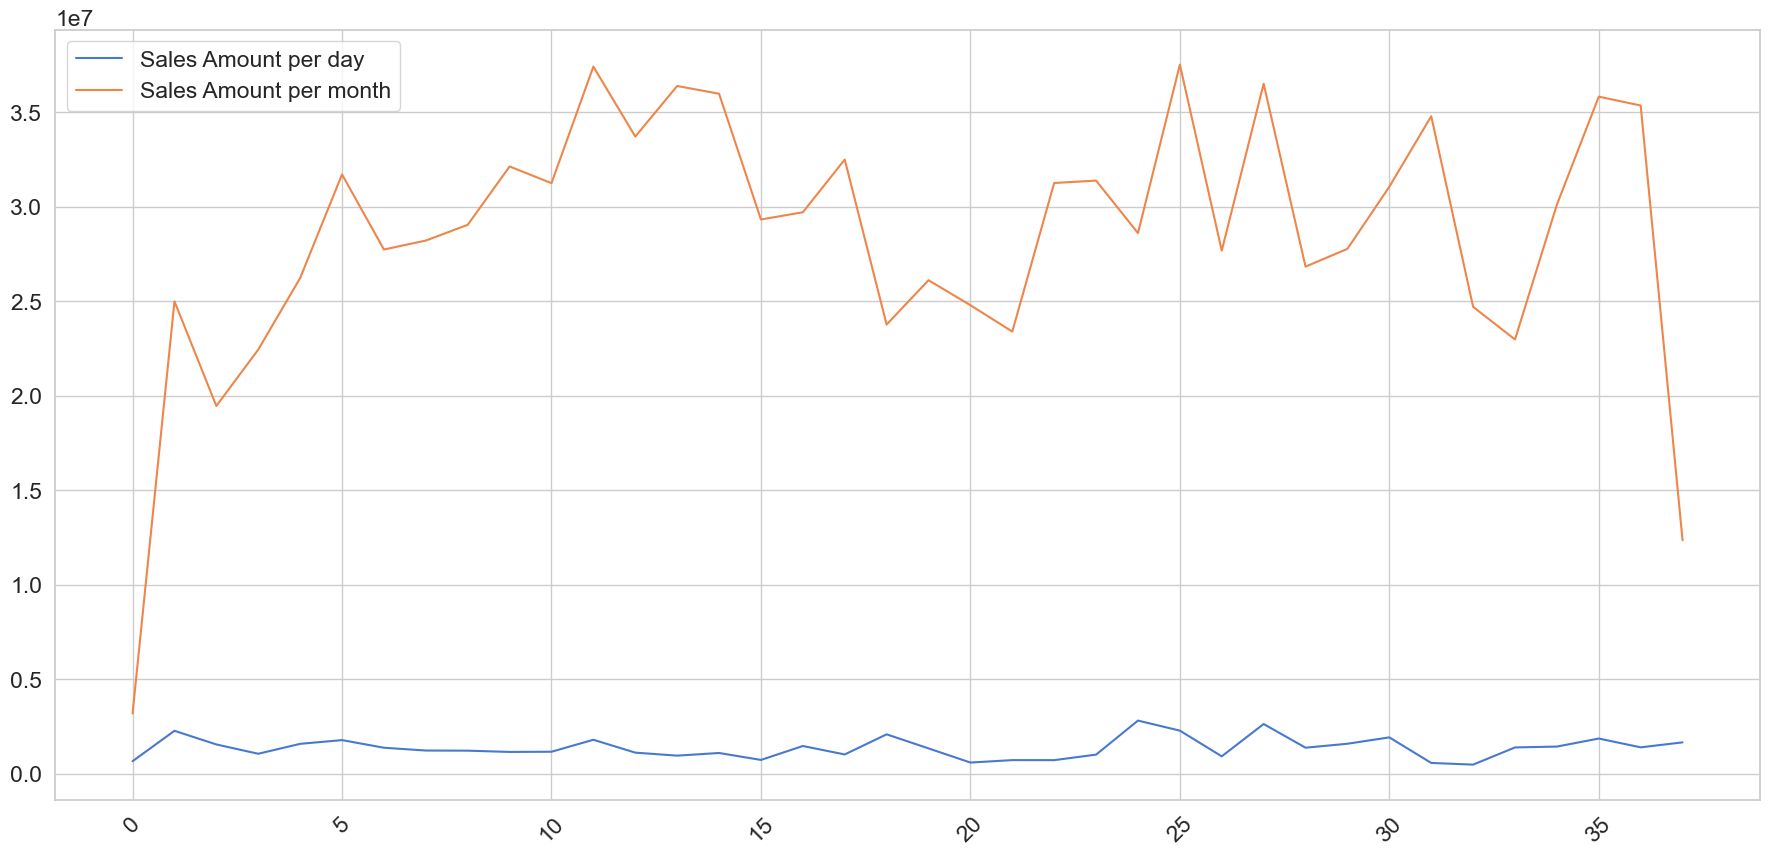

In [24]:
plt.plot(actual['Daily Sales'], label='Sales Amount per day')
plt.plot(actual['Monthly Sales'], label='Sales Amount per month')
plt.legend();
plt.xticks(rotation=45)

In [25]:
columns_to_scale = ['Daily Sales', 'Monthly Sales']

for columns in columns_to_scale:
    hmm[columns] = scaler.fit_transform(np.array(hmm[columns]).reshape(-1, 1))
    
scaled_data = hmm
scaled_data.head()

,Monthly Sales,Daily Sales
0,0.000000,0.077424
1,0.635159,0.768037
2,0.473922,0.458221
3,0.560784,0.246850
4,0.671071,0.471865


In [26]:
# The time series generator takes a sequence of numbers for x and y
# In this case we're sampling the same data, so X and Y have the same data
look_back=4
##################################################

# X = TimeseriesGenerator(scaled_data, scaled_data, length=look_back, batch_size=1)
##################################################

def df_to_X_y(df, look_back):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - look_back):
        row = [[a] for a in df_as_np[i:i+look_back]]
        X.append(row)
        label = df_as_np[i+look_back]
        y.append(label)
    return np.array(X), np.array(y)

In [28]:
EMX, EMy = df_to_X_y(scaled_data['Daily Sales'], look_back)
SMX, SMy = df_to_X_y(scaled_data['Monthly Sales'], look_back)
SMy.shape, EMy.shape

((34,), (34,))

In [29]:
SMy = np.expand_dims(SMy, axis=1)
EMy = np.expand_dims(EMy, axis=1)

In [30]:
X = np.concatenate((SMX, EMX), axis=1)
y = np.concatenate((SMy, EMy), axis=1)

In [31]:
# Split into training, testing and val.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.45, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.6, random_state=42, shuffle=True)
###################################################################################################################

In [32]:
len(X_train), len(y_train), len(X_test), len(y_test), len(X_val), len(y_val)

(18, 18, 6, 6, 10, 10)

In [33]:
################################################################################################################################
from tensorflow.keras.losses import MeanSquaredError                                                                           #
from tensorflow.keras.metrics import RootMeanSquaredError                                                                      #
from tensorflow.keras.models import Sequential                                                                                 #
from tensorflow.keras.layers import LSTM, Dense, Dropout                                                                       #
from tensorflow.keras.callbacks import ModelCheckpoint                                                                         #
from tensorflow.keras.optimizers import Adam                                                                                   #
################################################################################################################################

In [100]:
monthly_model = Sequential([
    LSTM(128, return_sequences=True, activation='tanh'),
#     Dropout(0.2),
    LSTM(128, activation='tanh'),
#     Dropout(0.2),
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(16, activation = 'relu'),
    Dense(2)
])
#Tried relu on LSTM(64) layers, batch size =2, learning rate=0.001, dropout=0.2, dense=32, lookback=3
#Tried tanh on LSTM(64) layers, batch size =2, learning rate=0.001, dropout=0.2, dense=32, lookback=3
#Tried tanh on LSTM(64) layers, batch size =2, learning rate=0.001, dropout=0.2, dense=32, lookback=4  ***
#Tried tanh on LSTM(64) layers, batch size =2, learning rate=0.001, dropout=0.1 on second layer, dense=32, lookback=4 ***

# monthly_model = Sequential([
#     LSTM(128, return_sequences=True,activation='relu'),
#     Dropout(0.3),
#     LSTM(128, return_sequences=True,activation='relu'),
#     Dropout(0.3),
#     LSTM(64, activation='relu'),
#     Dropout(0.2),
#     LSTM(64, activation='relu'),
#     Dropout(0.2),
#     Dense(32, activation = 'relu'),
#     Dense(2)
# ])

# monthly_model = Sequential([
#     LSTM(128, return_sequences=True, activation='tanh'),
#     LSTM(128, return_sequences=True, activation='sigmoid'),
#     LSTM(64, activation='relu'),
#     Dropout(0.2),
#     Dense(64, activation='relu'),
#     Dropout(0.2),
#     Dense(32, activation='relu'),
#     Dense(2)
# ])

In [101]:
monthly_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics = [RootMeanSquaredError()])

In [102]:
monthly_model.fit(X_train,y_train, validation_data=(X_val, y_val), epochs=700, batch_size=2 , verbose=2)

Epoch 1/700
9/9 - 10s - loss: 0.4133 - root_mean_squared_error: 0.6429 - val_loss: 0.3308 - val_root_mean_squared_error: 0.5752 - 10s/epoch - 1s/step
Epoch 2/700
9/9 - 0s - loss: 0.3227 - root_mean_squared_error: 0.5681 - val_loss: 0.1805 - val_root_mean_squared_error: 0.4249 - 304ms/epoch - 34ms/step
Epoch 3/700
9/9 - 0s - loss: 0.1307 - root_mean_squared_error: 0.3615 - val_loss: 0.0637 - val_root_mean_squared_error: 0.2523 - 313ms/epoch - 35ms/step
Epoch 4/700
9/9 - 0s - loss: 0.0745 - root_mean_squared_error: 0.2729 - val_loss: 0.0181 - val_root_mean_squared_error: 0.1345 - 284ms/epoch - 32ms/step
Epoch 5/700
9/9 - 0s - loss: 0.0520 - root_mean_squared_error: 0.2281 - val_loss: 0.0359 - val_root_mean_squared_error: 0.1895 - 268ms/epoch - 30ms/step
Epoch 6/700
9/9 - 0s - loss: 0.0525 - root_mean_squared_error: 0.2290 - val_loss: 0.0380 - val_root_mean_squared_error: 0.1950 - 367ms/epoch - 41ms/step
Epoch 7/700
9/9 - 0s - loss: 0.0635 - root_mean_squared_error: 0.2521 - val_loss: 0.0

Epoch 55/700
9/9 - 0s - loss: 0.0538 - root_mean_squared_error: 0.2319 - val_loss: 0.0460 - val_root_mean_squared_error: 0.2145 - 260ms/epoch - 29ms/step
Epoch 56/700
9/9 - 0s - loss: 0.0502 - root_mean_squared_error: 0.2240 - val_loss: 0.0313 - val_root_mean_squared_error: 0.1768 - 292ms/epoch - 32ms/step
Epoch 57/700
9/9 - 0s - loss: 0.0495 - root_mean_squared_error: 0.2224 - val_loss: 0.0290 - val_root_mean_squared_error: 0.1704 - 253ms/epoch - 28ms/step
Epoch 58/700
9/9 - 0s - loss: 0.0519 - root_mean_squared_error: 0.2278 - val_loss: 0.0334 - val_root_mean_squared_error: 0.1828 - 251ms/epoch - 28ms/step
Epoch 59/700
9/9 - 0s - loss: 0.0519 - root_mean_squared_error: 0.2278 - val_loss: 0.0230 - val_root_mean_squared_error: 0.1517 - 267ms/epoch - 30ms/step
Epoch 60/700
9/9 - 0s - loss: 0.0505 - root_mean_squared_error: 0.2248 - val_loss: 0.0327 - val_root_mean_squared_error: 0.1807 - 251ms/epoch - 28ms/step
Epoch 61/700
9/9 - 0s - loss: 0.0502 - root_mean_squared_error: 0.2240 - val

Epoch 109/700
9/9 - 0s - loss: 0.0505 - root_mean_squared_error: 0.2247 - val_loss: 0.0279 - val_root_mean_squared_error: 0.1671 - 264ms/epoch - 29ms/step
Epoch 110/700
9/9 - 0s - loss: 0.0488 - root_mean_squared_error: 0.2210 - val_loss: 0.0290 - val_root_mean_squared_error: 0.1704 - 267ms/epoch - 30ms/step
Epoch 111/700
9/9 - 0s - loss: 0.0487 - root_mean_squared_error: 0.2206 - val_loss: 0.0284 - val_root_mean_squared_error: 0.1684 - 266ms/epoch - 30ms/step
Epoch 112/700
9/9 - 0s - loss: 0.0494 - root_mean_squared_error: 0.2222 - val_loss: 0.0336 - val_root_mean_squared_error: 0.1832 - 267ms/epoch - 30ms/step
Epoch 113/700
9/9 - 0s - loss: 0.0489 - root_mean_squared_error: 0.2212 - val_loss: 0.0334 - val_root_mean_squared_error: 0.1827 - 268ms/epoch - 30ms/step
Epoch 114/700
9/9 - 0s - loss: 0.0506 - root_mean_squared_error: 0.2249 - val_loss: 0.0323 - val_root_mean_squared_error: 0.1798 - 266ms/epoch - 30ms/step
Epoch 115/700
9/9 - 0s - loss: 0.0485 - root_mean_squared_error: 0.220

Epoch 162/700
9/9 - 0s - loss: 0.0481 - root_mean_squared_error: 0.2193 - val_loss: 0.0291 - val_root_mean_squared_error: 0.1705 - 267ms/epoch - 30ms/step
Epoch 163/700
9/9 - 0s - loss: 0.0485 - root_mean_squared_error: 0.2202 - val_loss: 0.0283 - val_root_mean_squared_error: 0.1683 - 252ms/epoch - 28ms/step
Epoch 164/700
9/9 - 0s - loss: 0.0490 - root_mean_squared_error: 0.2214 - val_loss: 0.0342 - val_root_mean_squared_error: 0.1850 - 264ms/epoch - 29ms/step
Epoch 165/700
9/9 - 0s - loss: 0.0479 - root_mean_squared_error: 0.2189 - val_loss: 0.0325 - val_root_mean_squared_error: 0.1803 - 250ms/epoch - 28ms/step
Epoch 166/700
9/9 - 0s - loss: 0.0499 - root_mean_squared_error: 0.2234 - val_loss: 0.0299 - val_root_mean_squared_error: 0.1729 - 267ms/epoch - 30ms/step
Epoch 167/700
9/9 - 0s - loss: 0.0482 - root_mean_squared_error: 0.2196 - val_loss: 0.0325 - val_root_mean_squared_error: 0.1802 - 267ms/epoch - 30ms/step
Epoch 168/700
9/9 - 0s - loss: 0.0490 - root_mean_squared_error: 0.221

Epoch 215/700
9/9 - 0s - loss: 0.0476 - root_mean_squared_error: 0.2181 - val_loss: 0.0314 - val_root_mean_squared_error: 0.1771 - 264ms/epoch - 29ms/step
Epoch 216/700
9/9 - 0s - loss: 0.0461 - root_mean_squared_error: 0.2147 - val_loss: 0.0293 - val_root_mean_squared_error: 0.1712 - 281ms/epoch - 31ms/step
Epoch 217/700
9/9 - 0s - loss: 0.0488 - root_mean_squared_error: 0.2209 - val_loss: 0.0260 - val_root_mean_squared_error: 0.1614 - 299ms/epoch - 33ms/step
Epoch 218/700
9/9 - 0s - loss: 0.0494 - root_mean_squared_error: 0.2224 - val_loss: 0.0321 - val_root_mean_squared_error: 0.1792 - 255ms/epoch - 28ms/step
Epoch 219/700
9/9 - 0s - loss: 0.0504 - root_mean_squared_error: 0.2245 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1942 - 251ms/epoch - 28ms/step
Epoch 220/700
9/9 - 0s - loss: 0.0475 - root_mean_squared_error: 0.2179 - val_loss: 0.0298 - val_root_mean_squared_error: 0.1727 - 301ms/epoch - 33ms/step
Epoch 221/700
9/9 - 0s - loss: 0.0493 - root_mean_squared_error: 0.222

Epoch 268/700
9/9 - 0s - loss: 0.0492 - root_mean_squared_error: 0.2218 - val_loss: 0.0283 - val_root_mean_squared_error: 0.1681 - 283ms/epoch - 31ms/step
Epoch 269/700
9/9 - 0s - loss: 0.0479 - root_mean_squared_error: 0.2188 - val_loss: 0.0277 - val_root_mean_squared_error: 0.1665 - 268ms/epoch - 30ms/step
Epoch 270/700
9/9 - 0s - loss: 0.0492 - root_mean_squared_error: 0.2217 - val_loss: 0.0384 - val_root_mean_squared_error: 0.1960 - 393ms/epoch - 44ms/step
Epoch 271/700
9/9 - 0s - loss: 0.0446 - root_mean_squared_error: 0.2113 - val_loss: 0.0282 - val_root_mean_squared_error: 0.1678 - 385ms/epoch - 43ms/step
Epoch 272/700
9/9 - 0s - loss: 0.0468 - root_mean_squared_error: 0.2163 - val_loss: 0.0303 - val_root_mean_squared_error: 0.1741 - 306ms/epoch - 34ms/step
Epoch 273/700
9/9 - 0s - loss: 0.0527 - root_mean_squared_error: 0.2295 - val_loss: 0.0309 - val_root_mean_squared_error: 0.1758 - 299ms/epoch - 33ms/step
Epoch 274/700
9/9 - 0s - loss: 0.0461 - root_mean_squared_error: 0.214

Epoch 321/700
9/9 - 0s - loss: 0.0427 - root_mean_squared_error: 0.2066 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1942 - 268ms/epoch - 30ms/step
Epoch 322/700
9/9 - 0s - loss: 0.0429 - root_mean_squared_error: 0.2072 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1539 - 266ms/epoch - 30ms/step
Epoch 323/700
9/9 - 0s - loss: 0.0425 - root_mean_squared_error: 0.2062 - val_loss: 0.0393 - val_root_mean_squared_error: 0.1983 - 267ms/epoch - 30ms/step
Epoch 324/700
9/9 - 0s - loss: 0.0439 - root_mean_squared_error: 0.2095 - val_loss: 0.0428 - val_root_mean_squared_error: 0.2068 - 267ms/epoch - 30ms/step
Epoch 325/700
9/9 - 0s - loss: 0.0433 - root_mean_squared_error: 0.2081 - val_loss: 0.0299 - val_root_mean_squared_error: 0.1730 - 267ms/epoch - 30ms/step
Epoch 326/700
9/9 - 0s - loss: 0.0409 - root_mean_squared_error: 0.2023 - val_loss: 0.0419 - val_root_mean_squared_error: 0.2046 - 267ms/epoch - 30ms/step
Epoch 327/700
9/9 - 0s - loss: 0.0409 - root_mean_squared_error: 0.202

Epoch 374/700
9/9 - 0s - loss: 0.0375 - root_mean_squared_error: 0.1936 - val_loss: 0.0525 - val_root_mean_squared_error: 0.2290 - 252ms/epoch - 28ms/step
Epoch 375/700
9/9 - 0s - loss: 0.0357 - root_mean_squared_error: 0.1889 - val_loss: 0.0312 - val_root_mean_squared_error: 0.1766 - 266ms/epoch - 30ms/step
Epoch 376/700
9/9 - 0s - loss: 0.0379 - root_mean_squared_error: 0.1946 - val_loss: 0.0372 - val_root_mean_squared_error: 0.1930 - 267ms/epoch - 30ms/step
Epoch 377/700
9/9 - 0s - loss: 0.0338 - root_mean_squared_error: 0.1838 - val_loss: 0.0423 - val_root_mean_squared_error: 0.2056 - 252ms/epoch - 28ms/step
Epoch 378/700
9/9 - 0s - loss: 0.0300 - root_mean_squared_error: 0.1733 - val_loss: 0.0387 - val_root_mean_squared_error: 0.1967 - 251ms/epoch - 28ms/step
Epoch 379/700
9/9 - 0s - loss: 0.0319 - root_mean_squared_error: 0.1785 - val_loss: 0.0553 - val_root_mean_squared_error: 0.2351 - 251ms/epoch - 28ms/step
Epoch 380/700
9/9 - 0s - loss: 0.0286 - root_mean_squared_error: 0.169

Epoch 427/700
9/9 - 0s - loss: 0.0180 - root_mean_squared_error: 0.1340 - val_loss: 0.0661 - val_root_mean_squared_error: 0.2571 - 267ms/epoch - 30ms/step
Epoch 428/700
9/9 - 0s - loss: 0.0206 - root_mean_squared_error: 0.1434 - val_loss: 0.0712 - val_root_mean_squared_error: 0.2668 - 252ms/epoch - 28ms/step
Epoch 429/700
9/9 - 0s - loss: 0.0178 - root_mean_squared_error: 0.1333 - val_loss: 0.0645 - val_root_mean_squared_error: 0.2539 - 251ms/epoch - 28ms/step
Epoch 430/700
9/9 - 0s - loss: 0.0231 - root_mean_squared_error: 0.1519 - val_loss: 0.0499 - val_root_mean_squared_error: 0.2233 - 251ms/epoch - 28ms/step
Epoch 431/700
9/9 - 0s - loss: 0.0189 - root_mean_squared_error: 0.1375 - val_loss: 0.0595 - val_root_mean_squared_error: 0.2439 - 251ms/epoch - 28ms/step
Epoch 432/700
9/9 - 0s - loss: 0.0182 - root_mean_squared_error: 0.1348 - val_loss: 0.0619 - val_root_mean_squared_error: 0.2489 - 250ms/epoch - 28ms/step
Epoch 433/700
9/9 - 0s - loss: 0.0168 - root_mean_squared_error: 0.129

Epoch 480/700
9/9 - 0s - loss: 0.0097 - root_mean_squared_error: 0.0986 - val_loss: 0.0757 - val_root_mean_squared_error: 0.2751 - 265ms/epoch - 29ms/step
Epoch 481/700
9/9 - 0s - loss: 0.0096 - root_mean_squared_error: 0.0981 - val_loss: 0.0720 - val_root_mean_squared_error: 0.2683 - 252ms/epoch - 28ms/step
Epoch 482/700
9/9 - 0s - loss: 0.0096 - root_mean_squared_error: 0.0980 - val_loss: 0.0751 - val_root_mean_squared_error: 0.2740 - 267ms/epoch - 30ms/step
Epoch 483/700
9/9 - 0s - loss: 0.0107 - root_mean_squared_error: 0.1034 - val_loss: 0.0622 - val_root_mean_squared_error: 0.2493 - 251ms/epoch - 28ms/step
Epoch 484/700
9/9 - 0s - loss: 0.0110 - root_mean_squared_error: 0.1048 - val_loss: 0.0621 - val_root_mean_squared_error: 0.2493 - 251ms/epoch - 28ms/step
Epoch 485/700
9/9 - 0s - loss: 0.0108 - root_mean_squared_error: 0.1038 - val_loss: 0.0795 - val_root_mean_squared_error: 0.2819 - 298ms/epoch - 33ms/step
Epoch 486/700
9/9 - 0s - loss: 0.0100 - root_mean_squared_error: 0.100

Epoch 533/700
9/9 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0851 - val_loss: 0.0737 - val_root_mean_squared_error: 0.2716 - 268ms/epoch - 30ms/step
Epoch 534/700
9/9 - 0s - loss: 0.0078 - root_mean_squared_error: 0.0884 - val_loss: 0.0659 - val_root_mean_squared_error: 0.2567 - 249ms/epoch - 28ms/step
Epoch 535/700
9/9 - 0s - loss: 0.0076 - root_mean_squared_error: 0.0871 - val_loss: 0.0692 - val_root_mean_squared_error: 0.2630 - 255ms/epoch - 28ms/step
Epoch 536/700
9/9 - 0s - loss: 0.0080 - root_mean_squared_error: 0.0897 - val_loss: 0.0734 - val_root_mean_squared_error: 0.2709 - 267ms/epoch - 30ms/step
Epoch 537/700
9/9 - 0s - loss: 0.0067 - root_mean_squared_error: 0.0820 - val_loss: 0.0722 - val_root_mean_squared_error: 0.2686 - 266ms/epoch - 30ms/step
Epoch 538/700
9/9 - 0s - loss: 0.0063 - root_mean_squared_error: 0.0794 - val_loss: 0.0693 - val_root_mean_squared_error: 0.2633 - 318ms/epoch - 35ms/step
Epoch 539/700
9/9 - 0s - loss: 0.0064 - root_mean_squared_error: 0.080

Epoch 586/700
9/9 - 0s - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0704 - val_root_mean_squared_error: 0.2654 - 252ms/epoch - 28ms/step
Epoch 587/700
9/9 - 0s - loss: 0.0069 - root_mean_squared_error: 0.0829 - val_loss: 0.0621 - val_root_mean_squared_error: 0.2492 - 251ms/epoch - 28ms/step
Epoch 588/700
9/9 - 0s - loss: 0.0063 - root_mean_squared_error: 0.0795 - val_loss: 0.0636 - val_root_mean_squared_error: 0.2522 - 298ms/epoch - 33ms/step
Epoch 589/700
9/9 - 0s - loss: 0.0057 - root_mean_squared_error: 0.0752 - val_loss: 0.0710 - val_root_mean_squared_error: 0.2665 - 302ms/epoch - 34ms/step
Epoch 590/700
9/9 - 0s - loss: 0.0053 - root_mean_squared_error: 0.0726 - val_loss: 0.0631 - val_root_mean_squared_error: 0.2512 - 252ms/epoch - 28ms/step
Epoch 591/700
9/9 - 0s - loss: 0.0053 - root_mean_squared_error: 0.0731 - val_loss: 0.0662 - val_root_mean_squared_error: 0.2572 - 267ms/epoch - 30ms/step
Epoch 592/700
9/9 - 0s - loss: 0.0049 - root_mean_squared_error: 0.070

Epoch 639/700
9/9 - 0s - loss: 0.0083 - root_mean_squared_error: 0.0911 - val_loss: 0.0659 - val_root_mean_squared_error: 0.2568 - 267ms/epoch - 30ms/step
Epoch 640/700
9/9 - 0s - loss: 0.0042 - root_mean_squared_error: 0.0650 - val_loss: 0.0558 - val_root_mean_squared_error: 0.2362 - 297ms/epoch - 33ms/step
Epoch 641/700
9/9 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0529 - val_loss: 0.0566 - val_root_mean_squared_error: 0.2380 - 270ms/epoch - 30ms/step
Epoch 642/700
9/9 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0439 - val_loss: 0.0612 - val_root_mean_squared_error: 0.2474 - 267ms/epoch - 30ms/step
Epoch 643/700
9/9 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0451 - val_loss: 0.0562 - val_root_mean_squared_error: 0.2370 - 267ms/epoch - 30ms/step
Epoch 644/700
9/9 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0444 - val_loss: 0.0559 - val_root_mean_squared_error: 0.2364 - 298ms/epoch - 33ms/step
Epoch 645/700
9/9 - 0s - loss: 0.0026 - root_mean_squared_error: 0.051

Epoch 691/700
9/9 - 0s - loss: 9.8166e-08 - root_mean_squared_error: 3.1331e-04 - val_loss: 0.0545 - val_root_mean_squared_error: 0.2335 - 251ms/epoch - 28ms/step
Epoch 692/700
9/9 - 0s - loss: 6.2259e-08 - root_mean_squared_error: 2.4952e-04 - val_loss: 0.0545 - val_root_mean_squared_error: 0.2335 - 267ms/epoch - 30ms/step
Epoch 693/700
9/9 - 0s - loss: 6.9160e-08 - root_mean_squared_error: 2.6298e-04 - val_loss: 0.0545 - val_root_mean_squared_error: 0.2335 - 267ms/epoch - 30ms/step
Epoch 694/700
9/9 - 0s - loss: 6.5559e-08 - root_mean_squared_error: 2.5605e-04 - val_loss: 0.0545 - val_root_mean_squared_error: 0.2335 - 252ms/epoch - 28ms/step
Epoch 695/700
9/9 - 0s - loss: 4.8408e-08 - root_mean_squared_error: 2.2002e-04 - val_loss: 0.0545 - val_root_mean_squared_error: 0.2335 - 266ms/epoch - 30ms/step
Epoch 696/700
9/9 - 0s - loss: 3.2253e-08 - root_mean_squared_error: 1.7959e-04 - val_loss: 0.0545 - val_root_mean_squared_error: 0.2335 - 267ms/epoch - 30ms/step
Epoch 697/700
9/9 - 0s

<Axes: >

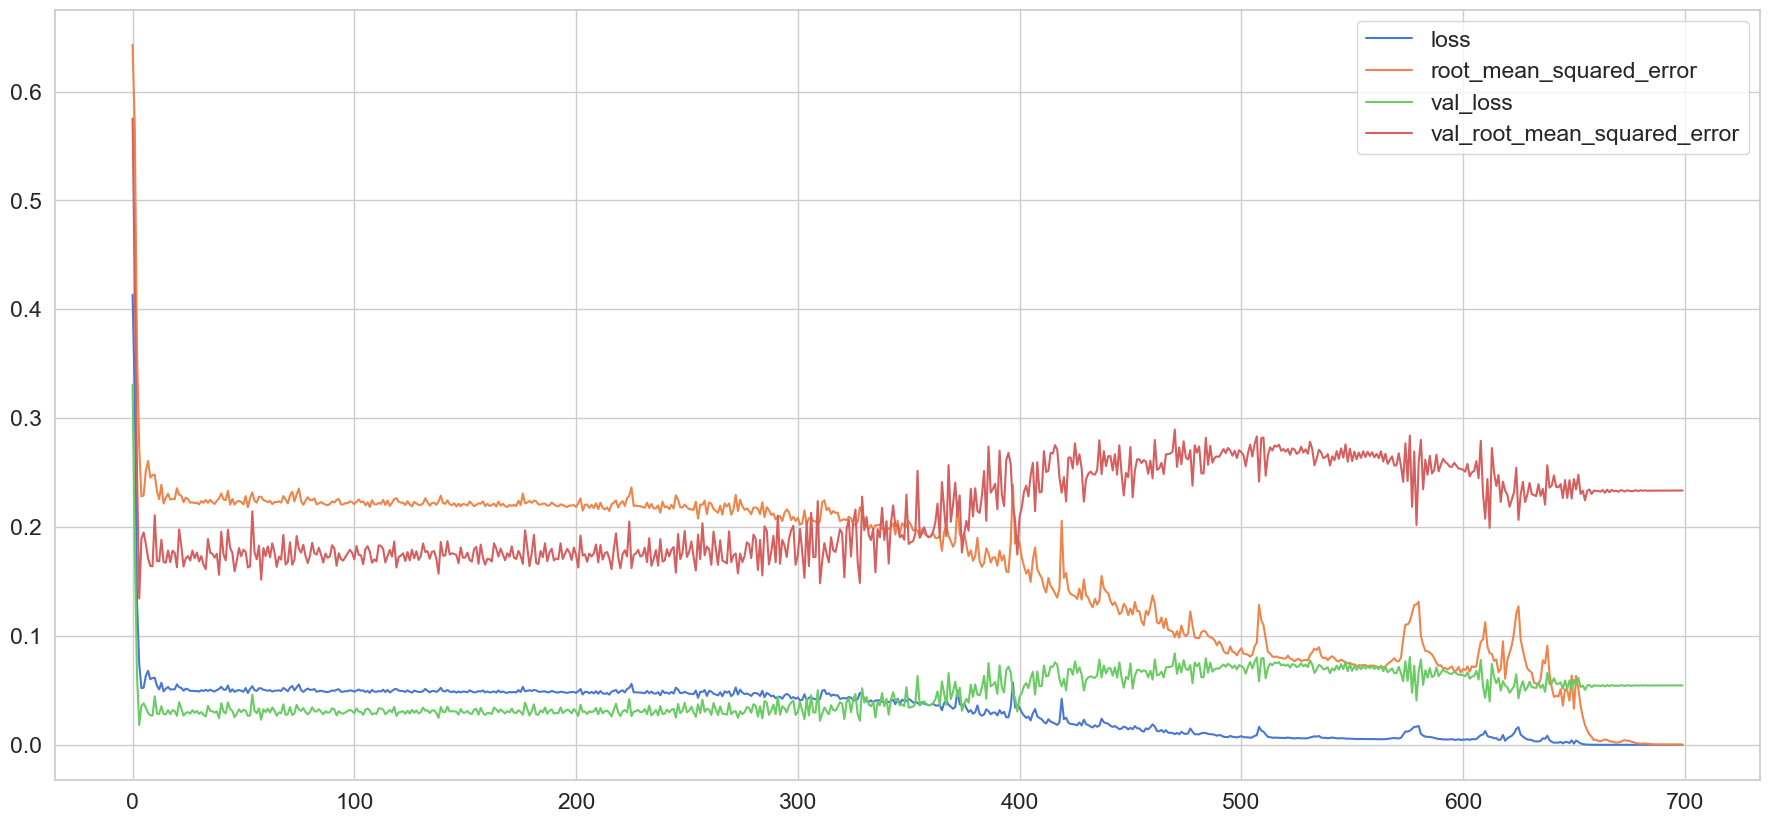

In [103]:
loss = pd.DataFrame(monthly_model.history.history)
loss.plot()

In [104]:
train_predict=monthly_model.predict(X)
train_predict=scaler.inverse_transform(train_predict)
train_predict.shape

2/2 [==============================] - 3s 16ms/step


(34, 2)

In [105]:
df = pd.DataFrame(train_predict, columns=['monthly sales', 'daily sales'])
df, len(df)

(    monthly sales  daily sales
 0      29473060.0  17855700.00
 1      31706568.0  22306670.00
 2      27725858.0  16351058.00
 3      28225196.0  14178178.00
 4      23820226.0   7906953.00
 5      18615612.0  16284664.00
 6      31232502.0  13237923.00
 7      37408148.0  22571648.00
 8      34683724.0  19993658.00
 9      34507364.0  22059784.00
 10     35978844.0  12268538.00
 11     29328052.0   6852640.50
 12     21533724.0  25599398.00
 13     21956268.0  29647684.00
 14     23767060.0  26808662.00
 15     26105992.0  23899052.00
 16     24498036.0  13140183.00
 17     26124980.0  11385265.00
 18     31255988.0   6688653.50
 19     31650364.0  25940134.00
 20     28604982.0  37515736.00
 21     30157252.0  30613758.00
 22     27674578.0   9664794.00
 23     36501852.0  34843496.00
 24     29846512.0  17803128.00
 25     27774572.0  19466190.00
 26     32039556.0  27582570.00
 27     26513322.0   9691080.00
 28     24701788.0   3197282.75
 29     22968098.0  16587770.00
 30     

In [106]:
actual = pd.DataFrame(data={' Daily Sales': sdf_daily, 'Monthly Sales':sdf_monthly})
actual = pd.DataFrame(np.array(actual[look_back:]), columns=['daily sales', 'monthly sales'])
actual, len(actual)

(    daily sales  monthly sales
 0       1585790       26225713
 1       1784118       31706881
 2       1380207       27735977
 3       1232128       28209077
 4       1224978       29040989
 5       1158278       32128017
 6       1168275       31244921
 7       1802021       37411276
 8       1120984       33710895
 9        961789       36385063
 10      1102110       35976421
 11       734380       29323893
 12      1471970       29705951
 13      1024476       32494700
 14      2089404       23765663
 15      1345410       26111337
 16       596444       24789659
 17       724950       23393838
 18       723634       31253918
 19      1015907       31380638
 20      2816369       28603720
 21      2284126       37515224
 22       925649       27673354
 23      2634992       36503395
 24      1381890       26830619
 25      1590996       27771010
 26      1928228       31056212
 27       575808       34787425
 28       486323       24703653
 29      1396202       22976497
 30     

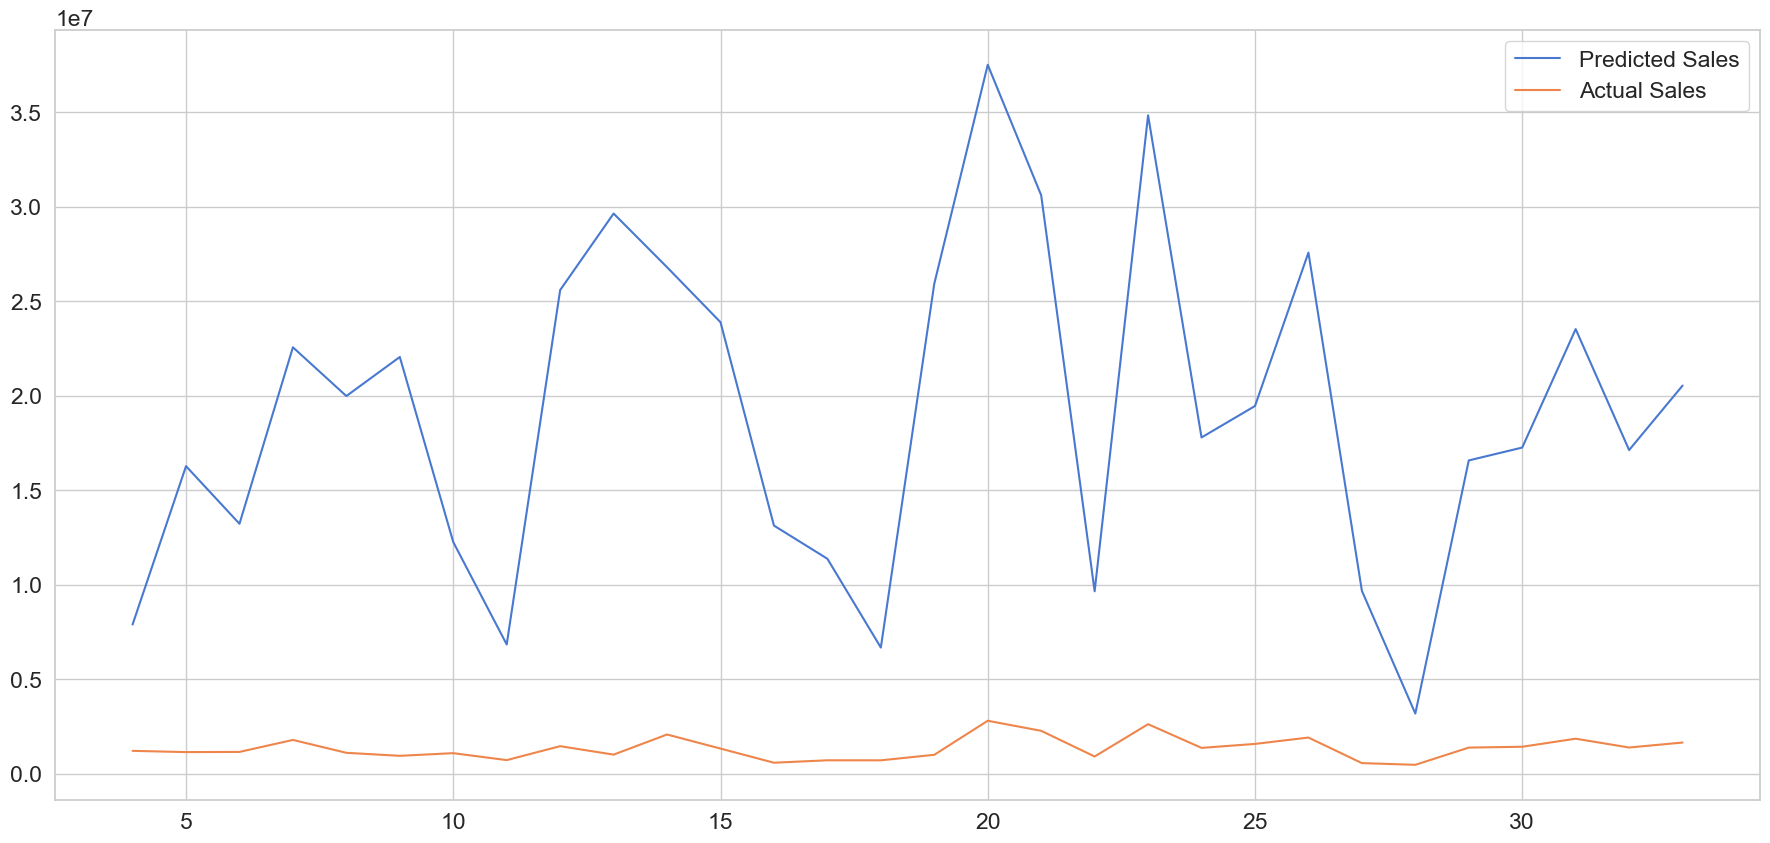

In [107]:
plt.plot(df.index[look_back:], df['daily sales'][look_back:], label='Predicted Sales')
plt.plot(df.index[look_back:], actual['daily sales'][look_back:], label='Actual Sales')
plt.legend()
plt.show()

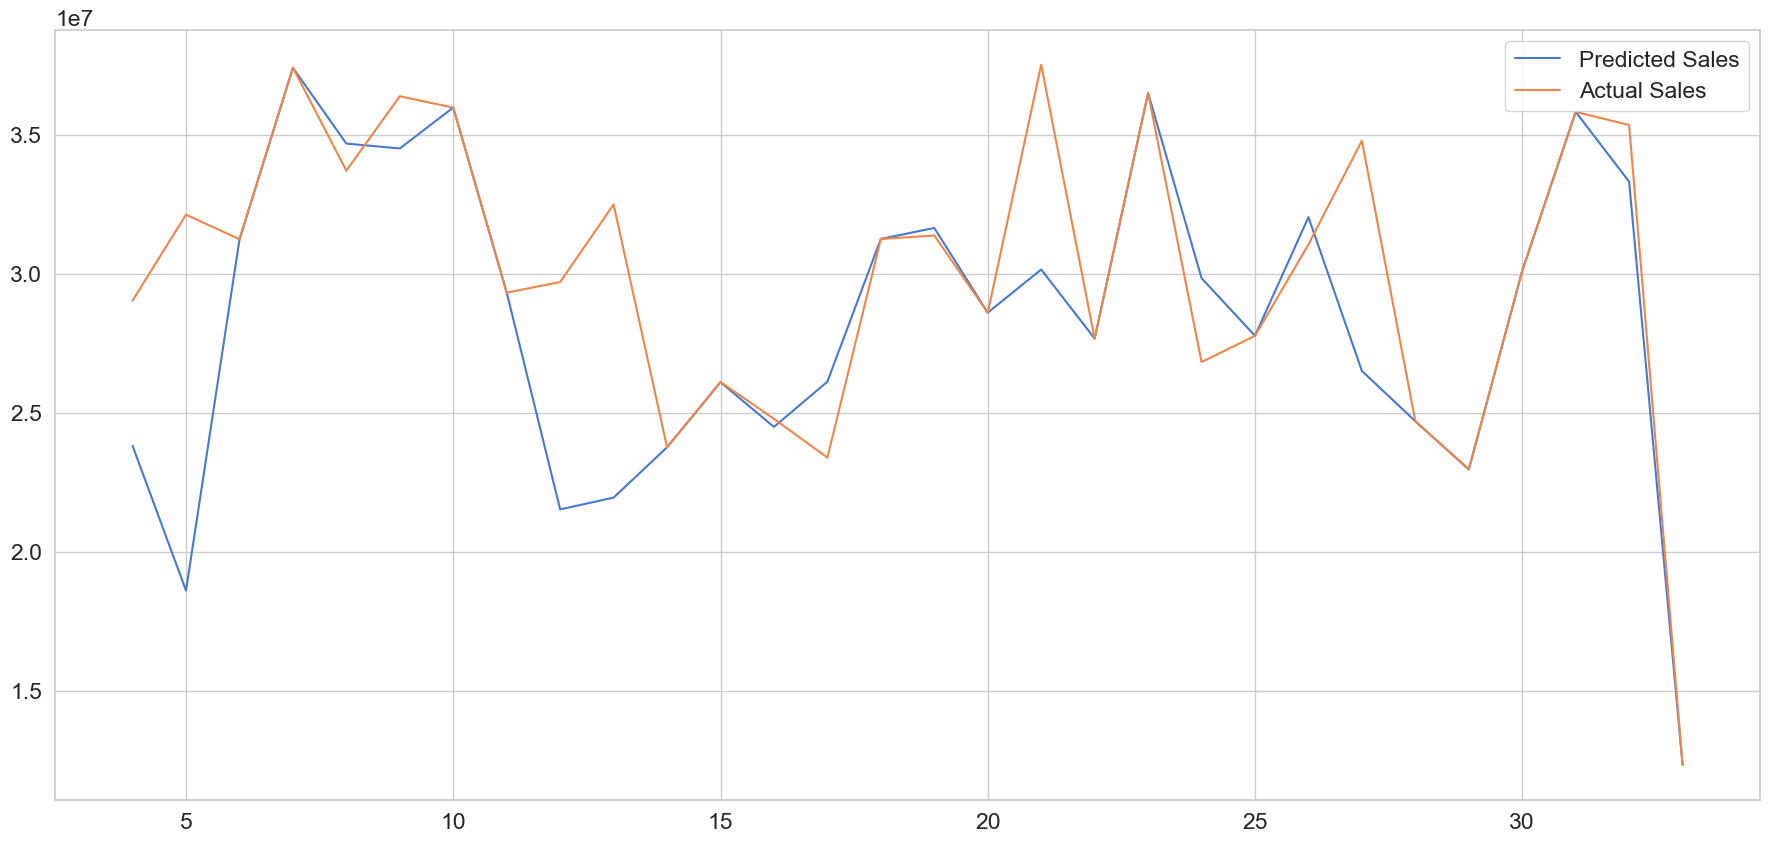

In [108]:
plt.plot(df.index[look_back:], df['monthly sales'][look_back:], label='Predicted Sales')
plt.plot(df.index[look_back:], actual['monthly sales'][look_back:], label='Actual Sales')
plt.legend()
plt.show()